# Lab 3
## Motion Capture Clustering

### Team members: Luay Dajani, Dana Geislinger, Chris Morgan, Caroll Rodriguez
##### Github - https://github.com/cdmorgan103/7331DataMiningNoShow

MSDS 7331, 12/02/2018

### Business Understanding 1
#### 10pts
Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific
dataset and the stakeholders needs?


https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures#

A Vicon motion capture camera system was used to record 12 users performing 5 hand postures with markers attached to a left-handed glove. 

A rigid pattern of markers on the back of the glove was used to establish a local coordinate system for the hand, and 11 other markers were attached to the thumb and fingers of the glove. 3 markers were attached to the thumb with one above the thumbnail and the other two on the knuckles. 2 markers were attached to each finger with one above the fingernail and the other on the joint between the proximal and middle phalanx. 

The 11 markers not part of the rigid pattern were unlabeled; their positions were not explicitly tracked. Consequently, there is no a priori correspondence between the markers of two given records. In addition, due to the resolution of the capture volume and self-occlusion due to the orientation and configuration of the hand and fingers, many records have missing markers. Extraneous markers were also possible due to artifacts in the Vicon software's marker reconstruction/recording process and other objects in the capture volume. As a result, the number of visible markers in a record varied considerably. 

The data presented here is already partially preprocessed. First, all markers were transformed to the local coordinate system of the record containing them. Second, each transformed marker with a norm greater than 200 millimeters was pruned. Finally, any record that contained fewer than 3 markers was removed. The processed data has at most 12 markers per record and at least 3. For more information, see 'Attribute Information'. 

Due to the manner in which data was captured, it is likely that for a given record and user there exists a near duplicate record originating from the same user. We recommend therefore to evaluate classification algorithms on a leave-one-user-out basis wherein each user is iteratively left out from training and used as a test set. One then tests the generalization of the algorithm to new users. A 'User' attribute is provided to accomodate this strategy. 

This dataset may be used for a variety of tasks, the most obvious of which is posture recognition via classification. One may also attempt user identification. Alternatively, one may perform clustering (constrained or unconstrained) to discover marker distributions either as an attempt to predict marker identities or obtain statistical descriptions/visualizations of the postures. 

### Data Understanding 1
#### 10pts
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [1]:
# Import required modules
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from matplotlib import style
from pprint import pprint
from IPython.display import display

# Load the data into variable 'df'
df = pd.read_csv('https://raw.githubusercontent.com/cdmorgan103/7331DataMiningNoShow/master/LAB3/Postures.csv')

# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78096 entries, 0 to 78095
Data columns (total 38 columns):
Class    78096 non-null int64
User     78096 non-null int64
X0       78096 non-null float64
Y0       78096 non-null float64
Z0       78096 non-null float64
X1       78096 non-null float64
Y1       78096 non-null float64
Z1       78096 non-null float64
X2       78096 non-null float64
Y2       78096 non-null float64
Z2       78096 non-null float64
X3       78096 non-null object
Y3       78096 non-null object
Z3       78096 non-null object
X4       78096 non-null object
Y4       78096 non-null object
Z4       78096 non-null object
X5       78096 non-null object
Y5       78096 non-null object
Z5       78096 non-null object
X6       78096 non-null object
Y6       78096 non-null object
Z6       78096 non-null object
X7       78096 non-null object
Y7       78096 non-null object
Z7       78096 non-null object
X8       78096 non-null object
Y8       78096 non-null object
Z8       78096 n

In [2]:
# we will remove class 0 
df = df[df.Class !=0 ]

#change ? to none to improve data format
df=df.replace({'?': 'NaN'})

#coerces into numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [3]:
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78095 entries, 1 to 78095
Data columns (total 38 columns):
Class    78095 non-null int64
User     78095 non-null int64
X0       78095 non-null float64
Y0       78095 non-null float64
Z0       78095 non-null float64
X1       78095 non-null float64
Y1       78095 non-null float64
Z1       78095 non-null float64
X2       78095 non-null float64
Y2       78095 non-null float64
Z2       78095 non-null float64
X3       77405 non-null float64
Y3       77405 non-null float64
Z3       77405 non-null float64
X4       74975 non-null float64
Y4       74975 non-null float64
Z4       74975 non-null float64
X5       65072 non-null float64
Y5       65072 non-null float64
Z5       65072 non-null float64
X6       52247 non-null float64
Y6       52247 non-null float64
Z6       52247 non-null float64
X7       38943 non-null float64
Y7       38943 non-null float64
Z7       38943 non-null float64
X8       30563 non-null float64
Y8       30563 non-null float64

since only 31 value appear for the 11th axis, we will delete this as a feature 

In [5]:
del df['X11']
del df['Y11']
del df['Z11']

### Data Understanding 2
#### 10pts
Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

### Modeling and Evaluation 1
#### 10 pts
Train and adjust parameters

### Modeling and Evaluation 2
#### 10pts
Evaluate and Compare

### Modeling and Evaluation 3
#### 10 pts
Visualize Results

### Modeling and Evaluation 4
#### 20 pts
Summarize the Ramifications

### Deployment 
#### 10 pts
Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

### Exceptional Work
#### 10 pts
You have free reign to provide additional analyses or combine analyses.

In [6]:
from mpl_toolkits import mplot3d

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [8]:
#filter certain users for plotting below
df_user6 = df[df.User == 6]
df_user14 = df[df.User == 14]
df_user5 = df[df.User == 5]
#One row in data table - represnts on set of data points
df_row48939 = df[48938:48939]

# feature categories
X_features = ['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']
Y_features = ['Y0','Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8','Y9','Y10']
Z_features = ['Z0','Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','Z10']

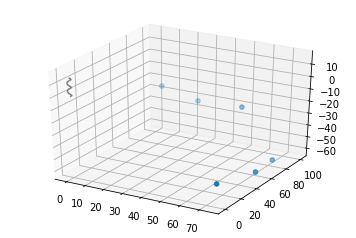

In [9]:
#one set of markers
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_row48939[Z_features].astype(float)
xdata = df_row48939[X_features].astype(float)
ydata = df_row48939[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

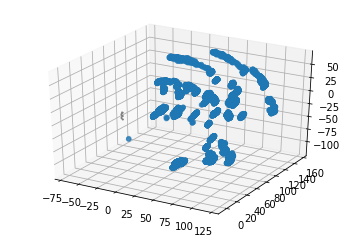

In [10]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user6[Z_features].astype(float)
xdata = df_user6[X_features].astype(float)
ydata = df_user6[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

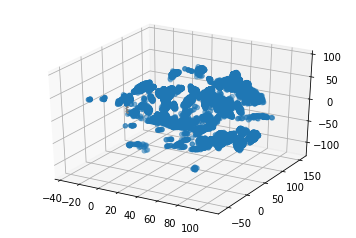

In [11]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user14[Z_features].astype(float)
xdata = df_user14[X_features].astype(float)
ydata = df_user14[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

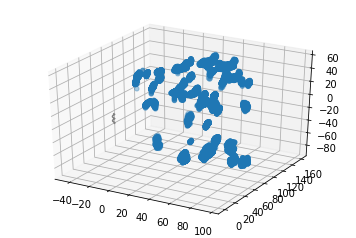

In [12]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user5[Z_features].astype(float)
xdata = df_user5[X_features].astype(float)
ydata = df_user5[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);